In [24]:
nome_tabela_produtos = "../data/products_500.xlsx"

# Importando as informações

In [25]:
# Importando a biblioteca pandas
import pandas as pd

In [26]:
# Importando os parâmetros dos conteiners
containersXLSX = pd.read_excel("../data/conteiners.xlsx", engine='openpyxl')
dataConteiners = containersXLSX.to_dict()

# Listas dos conteiners
weight_capacity_conteiner_list = list(dataConteiners.get("weight_capacity").values())
volume_capacity_conteiner_list = list(dataConteiners.get("volume_capacity").values())

containers = list()
for j in range(len(weight_capacity_conteiner_list)):
  containers.append("Conteiner_{}".format(j + 1))

quantityTotalConteiners = len(containers)

# Dicionários dos conteiners
weight_capacity_conteiner_dict = dict()
volume_capacity_conteiner_dict = dict()

for j in range(quantityTotalConteiners):
  weight_capacity_conteiner_dict[containers[j]] = weight_capacity_conteiner_list[j]
  volume_capacity_conteiner_dict[containers[j]] = volume_capacity_conteiner_list[j]

# Importando os parâmetros dos produtos
productsXLSX = pd.read_excel(nome_tabela_produtos, engine='openpyxl')
dataProducts = productsXLSX.to_dict()

# Listas dos produtos
volume_products_list = list(dataProducts.get("volume").values())
value_products_list = list(dataProducts.get("value").values())
weight_products_list = list(dataProducts.get("weight").values())
type_products_list = list(dataProducts.get("type").values())

products = list()
for i in range(len(volume_products_list)):
  products.append("Produto_{}".format(i + 1))

quantityTotalProducts = len(products)

# Dicionários dos produtos
volume_products_dict = dict()
value_products_dict = dict()
weight_products_dict = dict()
type_products_dict = dict()

for i in range(quantityTotalProducts):
  volume_products_dict[products[i]] = volume_products_list[i]
  value_products_dict[products[i]] = value_products_list[i]
  weight_products_dict[products[i]] = weight_products_list[i]
  type_products_dict[products[i]] = type_products_list[i]

# Importando os parâmetros das regras de compartilhamento
sharedXLSX = pd.read_excel("../data/shared.xlsx", engine='openpyxl', header=None)
T = sharedXLSX.values.tolist()

# Executando o algoritmo solver GUROBI

In [27]:
# Instalando a biblioteca gurobipy
!pip install gurobipy

In [28]:
# Importando a biblioteca gurobipy
import gurobipy as gp

WLSACCESSID="e06e00ea-72f7-4cf6-9bb6-0617ac182c15"
WLSSECRET="0fb5cf4d-d5e4-4fe9-a7df-fe42d0dbb0f2"
LICENSEID=2391225

# Crie um ambiente com seus
params = { "WLSACCESSID" : WLSACCESSID ,
 "WLSSECRET" : WLSSECRET ,
 "LICENSEID" : LICENSEID,
}

In [29]:
# Criando o modelo
env = gp.Env(params=params)
m = gp.Model(env=env)

objectiveIteration = []
types = ['food', 'pesticides', 'cleaning', 'clothing', 'appliances']

m.setParam(gp.GRB.Param.OutputFlag, 0)
m.setParam(gp.GRB.Param.TimeLimit, 7200)

# Métodos de execução
# -1=automatic,
# 0=primal simplex,
# 1=dual simplex,
# 2=barrier,
# 3=concurrent,
# 4=deterministic concurrent, and
# 5=deterministic concurrent simplex.
m.setParam(gp.GRB.Param.Method, 1)

# Variável de decisão
x = m.addVars(products, containers, vtype=gp.GRB.BINARY)

# Função objetivo
m.setObjective(gp.quicksum(x[i, j] * value_products_dict[i] for i in products for j in containers), sense=gp.GRB.MAXIMIZE)

# Restrição 1: O somatório dos volumes dos produtos alocados em uma conteiner, não pode ser maior que o volume conteiner
c1 = m.addConstrs(gp.quicksum(x[i, j] * volume_products_dict[i] for i in products) <= volume_capacity_conteiner_dict[j] for j in containers)

# Restrição 2: O somatório dos pesos dos produtos alocados em uma conteiner, não pode ser maior que a capacidade de peso suportada pela conteiner
c2 = m.addConstrs(gp.quicksum(x[i, j] * weight_products_dict[i] for i in products) <= weight_capacity_conteiner_dict[j] for j in containers)

# Restrição 3: O produto não pode ser transportado em mais de uma conteiner
c3 = m.addConstrs(gp.quicksum(x[i, j] for j in containers) <= 1 for i in products)

# Restrição 4: O produto não pode compartilhar a mesma conteiner com outro produto
for i in products:
  for k in products:
    if i!=k and T[types.index(type_products_dict[i])][types.index(type_products_dict[k])] == 0:
      m.addConstr(gp.quicksum(x[i, j] + x[k, j] for j in containers) <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2391225
Academic license - for non-commercial use only - registered to 20193018454@aluno.cefetmg.br


In [30]:
# Executando modelo
m.optimize()

bestValue = m.objVal

# Valor objetivo
print("Valor objetivo:", bestValue)
gap = m.MIPGap

# Valor gap
print("GAP:", gap)

# Itens nos containers
for j in containers:
  print(j)
  for i in products:
    if round(x[i, j].X) == 1:
        print(i, " ", end="")
  print("\n")

Valor objetivo: 4295.5
GAP: 4.888837155163226e-05
Conteiner_1
Produto_97  Produto_118  Produto_125  Produto_225  Produto_230  Produto_255  Produto_263  Produto_346  Produto_351  Produto_392  Produto_401  Produto_428  

Conteiner_2
Produto_8  Produto_16  Produto_58  Produto_60  Produto_115  Produto_141  Produto_162  Produto_183  Produto_227  Produto_249  Produto_261  Produto_281  Produto_282  Produto_299  Produto_365  Produto_391  Produto_409  Produto_440  Produto_457  Produto_462  Produto_483  Produto_484  Produto_489  Produto_495  Produto_497  

Conteiner_3
Produto_11  Produto_32  Produto_63  Produto_65  Produto_72  Produto_77  Produto_86  Produto_90  Produto_99  Produto_102  Produto_109  Produto_117  Produto_156  Produto_195  Produto_198  Produto_260  Produto_355  Produto_368  Produto_381  Produto_443  Produto_498  



# Algoritmo Genético (Heuristico)

In [31]:
import random

produtos = list()

for i in range(quantityTotalProducts):
  produtos.append({
      "valor": value_products_list[i],
      "volume": volume_products_list[i],
      "peso": weight_products_list[i],
      "tipo": type_products_list[i],
  })

numero_container = quantityTotalConteiners

containers = list()

for j in range(quantityTotalConteiners):
  containers.append({
      "volume": volume_capacity_conteiner_list[j],
      "capacidade_peso": weight_capacity_conteiner_list[j],
  })

# tipos de produtos que não podem ser colocados no mesmo container
indice_tipo_produto = {
    "food": 0,
    "pesticides": 1,
    "cleaning": 2,
    "clothing": 3,
    "appliances": 4
}

def calcular_fitness(individuo):
    valor_total = 0

    for i in range(len(individuo)):
        if individuo[i] != 0:
            valor_total += produtos[i]['valor']

    # penalizar individuos que nao respeitam as restricoes
    for container in range(len(containers)):
        numero_container = container + 1
        volume_total = 0
        peso_total = 0
        for i in range(len(individuo)):
            compartilhamento = True
            tipos_no_container = []
            if individuo[i] == numero_container:
                volume_total += produtos[i]['volume']
                peso_total += produtos[i]['peso']

                indicie_tipo = indice_tipo_produto[produtos[i]['tipo']]

                if tipos_no_container.count(indicie_tipo) == 0:
                    tipos_no_container.append(indicie_tipo)

            # avaliar se todos os tipos de produtos no container podem ser compartilhados
            for tipo in tipos_no_container:
                for tipo2 in tipos_no_container:
                    if tabela_compartilhamento[tipo][tipo2] == 0:
                        compartilhamento = False

            if compartilhamento == False:
                valor_total = 0
                break

        if volume_total > containers[container]['volume'] or peso_total > containers[container]['capacidade_peso']:
            valor_total = 0

    return valor_total

# alimento, agrotóxico, produto de higiene, vestuário, eletrodomestico
tabela_compartilhamento = T
def gerar_individuo(numero_container, numero_produtos, produtos_sorteados_multiplicador):
    individuo = [0 for i in range(numero_produtos)]

    produtos_sorteados = random.sample(range(numero_produtos), numero_container * produtos_sorteados_multiplicador)

    contador_container = 0
    for i in produtos_sorteados:
        individuo[i] = i % numero_container
        contador_container += 1

    if calcular_fitness(individuo) == 0:
        return gerar_individuo(numero_container, numero_produtos, produtos_sorteados_multiplicador)

    return individuo

def gerar_populacao(tamanho_populacao, numero_container, numero_produtos, produtos_sorteados_multiplicador):
    populacao = []
    for _ in range(tamanho_populacao):
        individuo = gerar_individuo(numero_container, numero_produtos, produtos_sorteados_multiplicador)
        populacao.append(individuo)
    return populacao

def crossover_multi_ponto(individuo1, individuo2, num_pontos):
    tamanho = len(individuo1)
    pontos_corte = random.sample(range(1, tamanho), num_pontos)  # Seleciona pontos de corte aleatórios

    pontos_corte.sort()  # Ordena os pontos de corte em ordem crescente

    filho1 = individuo1.copy()
    filho2 = individuo2.copy()

    for i in range(num_pontos + 1):
        inicio = pontos_corte[i - 1] if i > 0 else 0
        fim = pontos_corte[i] if i < num_pontos else tamanho

        if i % 2 == 0:
            filho1[inicio:fim] = individuo2[inicio:fim]
            filho2[inicio:fim] = individuo1[inicio:fim]
        else:
            filho1[inicio:fim] = individuo1[inicio:fim]
            filho2[inicio:fim] = individuo2[inicio:fim]

    return filho1, filho2


def avaliarPopulacao(populacao):
    fitness_populacao = []
    for individuo in populacao:
        fitness_populacao.append({ "fitness": calcular_fitness(individuo), "individuo": individuo })

    return fitness_populacao

def registrarEstatisticas(fitness_populacao, piores_individuos_geracao, melhores_individuos_geracao, media_fitness_geracao):
    piores_individuos_geracao.append(min([i['fitness'] for i in fitness_populacao if i['fitness'] > 0]))
    melhores_individuos_geracao.append(max([i['fitness'] for i in fitness_populacao if i['fitness'] > 0]))
    media_fitness_geracao.append(sum([i['fitness'] for i in fitness_populacao if i['fitness'] > 0]) / len([i['fitness'] for i in fitness_populacao if i['fitness'] > 0]))

def selecionarPais(tamanho_populacao, fitness_populacao):
    nova_populacao = []
    for _ in range(int(tamanho_populacao)):
        soma_fitness = sum([i['fitness'] for i in fitness_populacao])

        numero_sorteado = random.uniform(0, soma_fitness)

        soma = 0
        for i in fitness_populacao:
            soma += i['fitness']
            if soma > numero_sorteado:
                nova_populacao.append(i['individuo'])
                break

    return nova_populacao

def crossover(nova_populacao, taxa_crossover, numero_pontos_corte, elitismo):
    for i in range(0, len(nova_populacao), 2):
        if random.random() < taxa_crossover:
            filho1, filho2 = crossover_multi_ponto(nova_populacao[i], nova_populacao[i + 1], numero_pontos_corte)

            if elitismo:
                fitness_filho1 = {"f": calcular_fitness(filho1), "i": filho1}
                fitness_filho2 = {"f": calcular_fitness(filho2), "i": filho2}
                fitness_pai1 = {"f": calcular_fitness(nova_populacao[i]), "i": nova_populacao[i]}
                fitness_pai2 = {"f": calcular_fitness(nova_populacao[i + 1]), "i": nova_populacao[i + 1]}

                fitnesses = [fitness_filho1, fitness_filho2, fitness_pai1, fitness_pai2]

                fitnesses.sort(key=lambda x: x["f"], reverse=True)

                nova_populacao[i] = fitnesses[0]["i"]
                nova_populacao[i + 1] = fitnesses[1]["i"]
            else:
                nova_populacao[i] = filho1
                nova_populacao[i + 1] = filho2

def mutacao(nova_populacao, taxa_mutacao):
    for i in range(len(nova_populacao)):
        if random.random() < taxa_mutacao:
            ponto_corte = random.randint(0, len(produtos) - 1)
            novo_valor = random.randint(0, len(containers))
            nova_populacao[i][ponto_corte] = novo_valor

In [32]:
# codigo da função do genetico
def genetico(tamanho_populacao, numero_container, numero_produtos, taxa_crossover, numero_pontos_corte, taxa_mutacao, numero_geracoes, elitismo, produtos_sorteados_multiplicador):
    populacao = gerar_populacao(tamanho_populacao, numero_container, numero_produtos, produtos_sorteados_multiplicador)

    piores_individuos_geracao = []
    melhores_individuos_geracao = []
    media_fitness_geracao = []

    fitness_populacao = avaliarPopulacao(populacao)

    for geracao in range(numero_geracoes):
        print("Geracao: ", geracao)
        print("Fitness: ", max(fitness_populacao, key=lambda x: x['fitness'])['fitness'])

        fitness_populacao = avaliarPopulacao(populacao)

        registrarEstatisticas(fitness_populacao, piores_individuos_geracao, melhores_individuos_geracao, media_fitness_geracao)

        nova_populacao = selecionarPais(tamanho_populacao, fitness_populacao)

        crossover(nova_populacao, taxa_crossover, numero_pontos_corte, elitismo)

        mutacao(nova_populacao, taxa_mutacao)

        populacao = nova_populacao

    fitness_populacao = avaliarPopulacao(populacao)

    print("Fitness final: ", max(fitness_populacao, key=lambda x: x['fitness'])['fitness'])

    registrarEstatisticas(fitness_populacao, piores_individuos_geracao, melhores_individuos_geracao, media_fitness_geracao)

    melhor_individuo = max(fitness_populacao, key=lambda x: x['fitness'])['individuo']

    return piores_individuos_geracao, melhores_individuos_geracao, media_fitness_geracao, melhor_individuo

In [33]:
# Parâmetros do algoritmo genético
tamanho_populacao = 100
taxa_crossover = 0.38
taxa_mutacao = 0.1
numero_geracoes = 300
elitismo = True
produtos_sorteados_multiplicador = 8
numero_pontos_corte = 50
produtos_sorteados_multiplicador = 8

piores_individuos_geracao, melhores_individuos_geracao, media_fitness_geracao, melhor_individuo = genetico(tamanho_populacao, len(containers), len(produtos), taxa_crossover, numero_pontos_corte, taxa_mutacao, numero_geracoes, elitismo, produtos_sorteados_multiplicador)


Geracao:  0
Fitness:  1113.5200000000002
Geracao:  1
Fitness:  1113.5200000000002
Geracao:  2
Fitness:  1113.5200000000002
Geracao:  3
Fitness:  1192.3899999999999
Geracao:  4
Fitness:  1157.6799999999998
Geracao:  5
Fitness:  1272.76
Geracao:  6
Fitness:  1272.76
Geracao:  7
Fitness:  1326.97
Geracao:  8
Fitness:  1370.79
Geracao:  9
Fitness:  1428.6
Geracao:  10
Fitness:  1532.5199999999998
Geracao:  11
Fitness:  1536.5600000000002
Geracao:  12
Fitness:  1645.57
Geracao:  13
Fitness:  1645.57
Geracao:  14
Fitness:  1556.1699999999998
Geracao:  15
Fitness:  1707.98
Geracao:  16
Fitness:  1707.98
Geracao:  17
Fitness:  1757.3999999999999
Geracao:  18
Fitness:  1770.3000000000002
Geracao:  19
Fitness:  1849.7
Geracao:  20
Fitness:  1893.5299999999997
Geracao:  21
Fitness:  2002.26
Geracao:  22
Fitness:  2002.26
Geracao:  23
Fitness:  2117.32
Geracao:  24
Fitness:  2150.91
Geracao:  25
Fitness:  2150.91
Geracao:  26
Fitness:  2150.91
Geracao:  27
Fitness:  2271.36
Geracao:  28
Fitness:  

GAP:  0.0


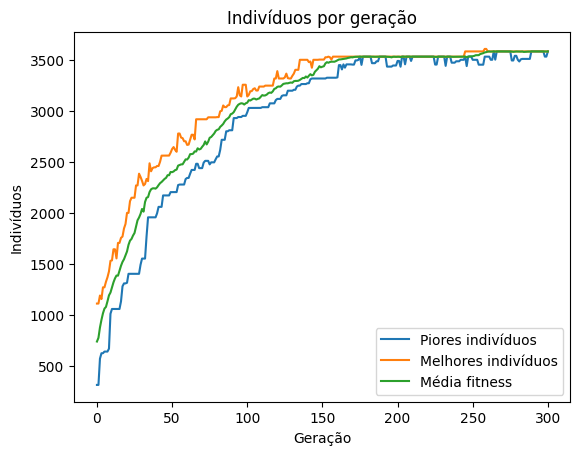

In [34]:
import matplotlib.pyplot as plt

melhor_valor_encontrado = melhores_individuos_geracao[-1] # subistituir pelo melhor valor

print("GAP: ", abs((melhores_individuos_geracao[-1] - melhor_valor_encontrado)) / abs(melhor_valor_encontrado))

def plotar_grafico(arr1, arr2, arr3, label):
    plt.plot(arr1)
    plt.plot(arr2)
    plt.plot(arr3)
    plt.title(label + " por geração")
    plt.ylabel(label)
    plt.xlabel('Geração')
    plt.legend(["Piores indivíduos", "Melhores indivíduos", "Média fitness"])
    plt.show()

plotar_grafico(piores_individuos_geracao, melhores_individuos_geracao, media_fitness_geracao, "Indivíduos")